## Toy example

In [13]:
import tensorflow as tf
assert tf.__version__=='2.2.0-rc1'

In [20]:
tf.__version__

'2.2.0-rc1'

In [14]:
HEIGHT = 20
WIDTH = 20
TENERGY = 10e3
TLOCMAX = 100
TNUMBER = 3
# good values to test if recursive function works
TSEED = tf.constant(1000, tf.float32)  # tf.constant([300.], tf.float32)
TNEIGHBOR = tf.constant(100., tf.float32)
TCELL = tf.constant(50., tf.float32)

(20, 20, 2)

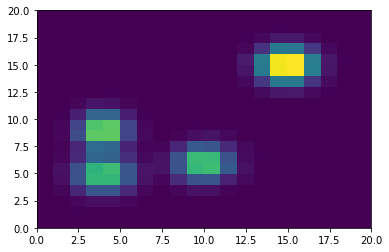

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
X = np.vstack((np.random.multivariate_normal(mean=[2+2,3+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[2+2,7+2], cov=[[0.7,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[8+2,4+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[15,15], cov=[[1,0],[0,1]], size=15000)))
A = plt.hist2d(X[:,0], X[:,1], bins=HEIGHT, range=[[0, HEIGHT], [0, WIDTH]])[0]
# plt.imshow(A)
# B = A[..., np.newaxis]
A[:2,6] = 1.5*TNEIGHBOR
A[0,7:9] = 1.5*TCELL
A[1,5] = 0
A[3,16] = 20*TSEED

B = np.stack((A,0.5*A), axis=-1).astype(np.float32)
np.shape(B)

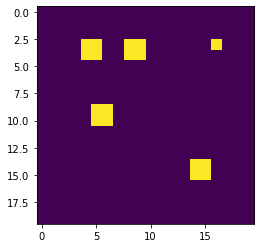

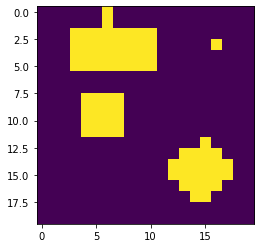

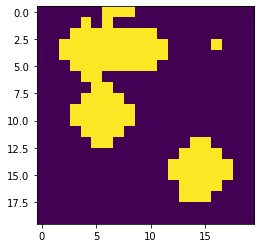

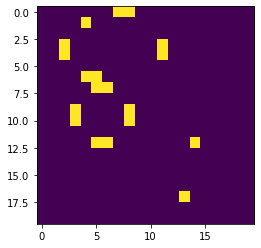

In [16]:
plt.imshow(A > TSEED)
plt.show()
plt.imshow(A > TNEIGHBOR)
plt.show()
plt.imshow(A > TCELL)
plt.show()
plt.imshow((A > TCELL) & (A <= TNEIGHBOR))
plt.show()

In [23]:
from skimage.measure import label

f = lambda x: skimage.measure.label(x, connectivity=2)

@tf.function
def finding_seeds(image):
    """Finding seeds and create seed list"""
    seed_mask = tf.math.greater(image, TSEED)
    labels = tf.numpy_function(f, [seed_mask], Tout=tf.int64)
    seed_idx = tf.where(tf.not_equal(labels, 0))
    seed_id = tf.expand_dims(tf.gather_nd(labels, seed_idx), axis=1)
    seed_list = tf.concat([seed_id, seed_idx], axis=-1)
    return seed_list

In [276]:
@tf.function
def sorting_seedlist(s, m):
    """Sorts current seed list in descending order"""
    sid, sidx = tf.split(s, num_or_size_splits=[1,3], axis=1)
    seeds = tf.gather_nd(m, sidx)
    indices = tf.math.top_k(seeds, k=tf.shape(s)[0])[1]
    return tf.gather(s, indices)

In [277]:
@tf.function
def neighbors(index, excl=tf.zeros([0, 3], tf.int64), incl=tf.zeros([0, 3], tf.int64)):
    """8-1 connectivity"""
    
    # indices of 3x3x1 centred at (i,j,k)
    i, j, k = tf.unstack(index)
    ii, jj = tf.meshgrid(tf.range(i-1, i+2), tf.range(j-1, j+2), indexing='ij')
    ii = tf.reshape(ii, [-1, 1])
    jj = tf.reshape(jj, [-1, 1])
    kk = tf.repeat(tf.reshape(k, (1, 1)), repeats=[9], axis=0)
    a = tf.concat([ii, jj, kk], axis=-1)
    
    # append index (i,j) in other k channel
    a = tf.concat([a, [[i, j, tf.math.abs(k-1)]]], axis=0)
    
    # remove centre point (i,j,k)
    mask_centre = tf.reduce_any(tf.not_equal(a, index), axis=-1)
    
    # remove points outside image
    b = tf.expand_dims(a, axis=-1)
    c = tf.transpose(tf.constant([[HEIGHT,-1, -1], [-1,WIDTH,-1]], dtype=b.dtype))
    mask_boundary = tf.reduce_all(tf.not_equal(b, c), axis=[-2,-1])
    mask = tf.logical_and(mask_centre, mask_boundary)
    a = tf.boolean_mask(a, mask)
    
    # remove points in excl and only consider points in incl
    a_sp = tf.SparseTensor(a, tf.ones(tf.shape(a)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    a_d = tf.sparse.to_dense(tf.sparse.reorder(a_sp))
    excl_sp = tf.SparseTensor(excl, tf.ones(tf.shape(excl)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    excl_d = tf.sparse.to_dense(tf.sparse.reorder(excl_sp))
    incl_sp = tf.SparseTensor(incl, tf.ones(tf.shape(incl)[0], dtype=tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    incl_d = tf.sparse.to_dense(tf.sparse.reorder(incl_sp))
    mask_final = tf.logical_and(a_d, tf.logical_not(excl_d))
    
    true_fn = lambda: tf.logical_and(mask_final, incl_d)
    mask_final = tf.cond(tf.greater(tf.shape(incl)[0], 0), true_fn, lambda: mask_final)
    
    neighbors = tf.where(mask_final)
    return neighbors

In [278]:
def merge_adjacent_proto(nj, siid, m, p, s, l):
    """Merge adjacent proto-clusters"""
    sid, sidx = tf.split(s, num_or_size_splits=[1,3], axis=1)
    lid, lidx = tf.split(l, num_or_size_splits=[1,3], axis=1)
    proto_id, proto_idx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    nnj = neighbors(nj, excl=sidx)
    nnj_sp = tf.SparseTensor(nnj, tf.ones(tf.shape(nnj)[0], tf.bool), dense_shape=[HEIGHT, WIDTH, 2])
    nnj_d = tf.sparse.to_dense(tf.sparse.reorder(nnj_sp))
    proto_sp = tf.SparseTensor(proto_idx, tf.reshape(proto_id, [-1,]), dense_shape=[HEIGHT, WIDTH, 2])
    proto_d = tf.sparse.to_dense(tf.sparse.reorder(proto_sp))
    indices = tf.where(tf.logical_and(tf.logical_and(nnj_d, tf.not_equal(proto_d, 0)), tf.greater(m, TNEIGHBOR)))
#     indices = tf.where(tf.logical_and(nnj_d, tf.not_equal(proto_d, 0)))
    values = tf.gather_nd(proto_d, indices)
    values = tf.boolean_mask(values, tf.not_equal(values, siid))
    
    # loop over values
    k0 = tf.constant(0)
    ck = lambda k, p, s, l: tf.less(k, tf.shape(values)[0])
    def bk(k, p, s, l):
        neigh_id = tf.gather(values, k)
        pnew = tf.where(tf.equal(proto_d, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(p), p)
        snew = tf.where(tf.equal(sid, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(s), s)
        lnew = tf.where(tf.equal(lid, neigh_id), tf.reshape(siid, [-1,])*tf.ones_like(l), l)
        return [tf.add(k, 1), pnew, snew, lnew]
    k, p, sid, lid = tf.while_loop(ck, bk, loop_vars=[k0, proto_d, sid, lid],
                                   shape_invariants=[k0.get_shape(), proto_d.get_shape(),
                                                     sid.get_shape(), lid.get_shape()])                
    indices = tf.where(tf.not_equal(p, 0))
    values = tf.expand_dims(tf.gather_nd(p, indices), axis=1)
    pnew = tf.concat([values, indices], axis=1)
    snew = tf.concat([sid, sidx], axis=1)
    lnew = tf.concat([lid, lidx], axis=1)
    return [pnew, snew, lnew]


def bj_maker(j, m, p, s, l, n, siid):
    """Body of while loop over neighbors"""
    nj = tf.gather(n, j)
    nval = tf.gather_nd(m, nj)
    nnew = tf.expand_dims(tf.concat([siid, nj], axis=0), axis=0)

    def tneighbor(siid=siid):
        """Append cells to both proto-clusters and neighbor seed list if value above TNEIGHBOR"""
        [pnew, snew, lnew] = merge_adjacent_proto(nj, siid, m, p, s, l)
        pnew = tf.concat([pnew, nnew], axis=0)
        lnew = tf.concat([lnew, nnew], axis=0)
        return [pnew, snew, lnew]

    def tcell():
        """Append cells to proto-clusters if value above TCELL"""
        def true_fn():
            return tf.concat([p, nnew], axis=0)
        def false_fn(): return p
        pnew = tf.cond(tf.greater(nval, TCELL), true_fn, false_fn)
        return [pnew, s, l]
    
    [pnew, snew, lnew] = tf.cond(tf.greater(nval, TNEIGHBOR), true_fn=tneighbor, false_fn=tcell)
    
    return [tf.add(j, 1), m, pnew, snew, lnew, n, siid]
    

def bi_maker(i, m, p, s, l):
    """Body of while loop over current seed list"""
    si = tf.gather(s, i)
    
    # find neighbours not in protolist
    siid, siidx = tf.split(si, num_or_size_splits=[1,3], axis=0)
    _, pidx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    n = neighbors(siidx, excl=pidx)
        
    # loop over neighbors
    j0 = tf.constant(0)
    cj = lambda j, m, p, s, l, n, siid: tf.less(j, tf.shape(n)[0])
    _, m, p, s, l, _, _ = tf.while_loop(
        cj, bj_maker, loop_vars=[j0, m, p, s, l, n, siid],
        shape_invariants=[j0.get_shape(), m.get_shape(), tf.TensorShape([None, 4]),
                          s.get_shape(), tf.TensorShape([None, 4]),
                          n.get_shape(), siid.get_shape()])
    
    return [tf.add(i, 1), m, p, s, l]
  
def finding_neighbors_maker(m, p, s):
    # sort current seed list in descending order
    ssort = sorting_seedlist(s, m)
    
    # loop over current seed list
    i0 = tf.constant(0)
    l0 = tf.zeros([0,4], tf.int64)
    ci = lambda i, m, p, s, l: tf.less(i, tf.shape(ssort)[0])
    _, m, pnew, s, lnew = tf.while_loop(
        ci, bi_maker, loop_vars=[i0, m, p, s, l0],
        shape_invariants=[i0.get_shape(), m.get_shape(), tf.TensorShape([None, 4]),
                          s.get_shape(), tf.TensorShape([None, 4])])
    
    # neighbor seed list becomes the new seed list
    return pnew, lnew

In [344]:
@tf.function
def finalize_maker(m, p, hwc):
    """Filter clusters by energy threshold"""
    pid, pidx = tf.split(p, num_or_size_splits=[1,3], axis=1)
    psp = tf.SparseTensor(pidx, tf.reshape(pid, [-1,]), dense_shape=hwc)
    pd = tf.sparse.to_dense(tf.sparse.reorder(psp))
    tf.print(hwc, pid)
    u, uid = tf.unique(tf.reshape(sid, [-1]), out_idx=sid.dtype)
#     i0 = tf.constant(1, s_dense.dtype)
#     c = lambda i: tf.less(i, tf.cast(ulen+1, s_dense.dtype))
#     def b(i):
#         indices = tf.where(tf.equal(s_dense, i))
#         values = tf.gather_nd(m, indices)
#         Ei = tf.expand_dims(tf.reduce_sum(values), axis=0)
#         return [tf.add(i, 1), tf.concat([E, Ei], axis=0)]
#     _, E = tf.while_loop(c, b, loop_vars=[i0, E0], shape_invariants=[i0.get_shape(), tf.TensorShape([None, 1])])
#     print("total cluster energy", E)
    return p

In [345]:
@tf.function
def cluster_maker(parsed):
    """m: image, p: protolist, s: seedlist, l: neighlist, n: neighbor"""
    s = finding_seeds(parsed['image'])
    
    # finding neighbours recursively until current seed list is empty
    c = lambda pi, si: tf.not_equal(tf.size(si), 0)
    b = lambda pi, si: finding_neighbors_maker(parsed['image'], pi, si)
    pnew = tf.while_loop(c, b, loop_vars=[s, s],
                         shape_invariants=[tf.TensorShape([None, 4]), tf.TensorShape([None, 4])])[0]
    
    parsed = parsed.copy()
    parsed['proto'] = finalize_maker(parsed['image'], pnew, parsed['hwc'])
#     parsed['proto'] = pnew
    return parsed

In [346]:
# tf.constant(B)

In [347]:
dataset = tf.data.Dataset.from_tensor_slices({'image': tf.expand_dims(tf.constant(B), axis=0), 
                                             'hwc': tf.constant([[HEIGHT, WIDTH, 2]], tf.int64)})
mapped = dataset.map(cluster_maker)
# for i in dataset:
#     print(i['image'].shape)

In [348]:
for output in mapped.take(1):
    print(tf.shape(output['proto']))

[20 20 2] [[2]
 [2]
 [2]
 ...
 [5]
 [5]
 [2]]
tf.Tensor([166   4], shape=(2,), dtype=int32)


In [324]:
# output = cluster_maker({'image': tf.constant(B)})

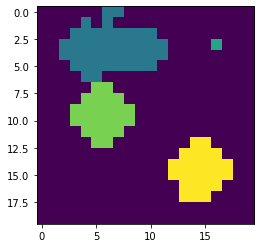

In [284]:
A = output['proto'].numpy()
# print(A)
# A = A[...,1:]
A1 = A[A[...,3] == 0][...,:3]
A2 = A[A[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A1_dense)

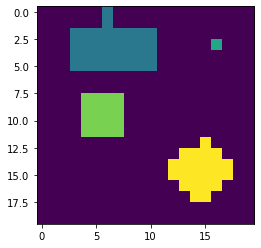

In [285]:
sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A2_dense)

In [ ]:
# output2['cluster']

In [ ]:
# output = cluster_maker({'image': B})
output2 = cluster_splitter(output)
# output2

In [ ]:
scalar_features(output2)

In [ ]:
C = output2['cluster'].numpy()
# plt.
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
C1 = C1[C1[...,0] == 1]
# C1 = np.unique(C1, axis=0)
# C2 = np.unique(C2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

In [ ]:
C = output2['cluster'].numpy()
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

In [ ]:
sp = tf.SparseTensor(C2[...,1:3], C2[...,0], dense_shape=[HEIGHT,WIDTH])
C2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C2_dense)

## Unit testing

In [ ]:
def test_sorting():
    # arrange
    image = tf.constant([[[3., 2.], [6., 1.]], [[5., 8.], [7., 4.]]])
    TSEED = 4.
    seed_list = tf.where(tf.math.greater(image, TSEED))
    seed_len = 4
    
    # act
    sorted_seedlist = sorting(seed_list, seed_len, image)
    
    # assert
    assert tf.equal(sorted_seedlist, tf.constant([[1,0,1], [1,1,0], [0,1,0], [1,0,0]], tf.int64)).numpy().all()

In [ ]:
def test_neighbors():
    # arrange
    index = tf.constant([0,0,0], tf.int64)
    seed_list = tf.constant([[1,0,0], [1,1,0], [1,2,0]], tf.int64)
    
    # act
    neigh = neighbors(index, seed_list)
    
    # assert
    assert tf.equal(neigh, tf.constant([[0,0,1], [0,1,0]], tf.int64)).numpy().all()

In [ ]:
test_neighbors()
# test_sorting()

In [119]:
a = tf.constant([6, 5, 4, 3, 2, 1])
c = lambda a: tf.not_equal(tf.size(a), 0)
def b(a): tf.print(a); return [tf.strided_slice(a, [0], [-1], [1])]
r = tf.while_loop(c, b, [a])

[6 5 4 3 2 1]
[6 5 4 3 2]
[6 5 4 3]
[6 5 4]
[6 5]
[6]


In [120]:
r

[<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>]

In [140]:
b = tf.constant([[1,2,3], [4,5,6]])
b

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

In [142]:
tf.map_fn(lambda x: x+tf.constant([0, 1, 1]), b)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 3, 4],
       [4, 6, 7]], dtype=int32)>

In [143]:
tf.constant([[]])

<tf.Tensor: shape=(1, 0), dtype=float32, numpy=array([], shape=(1, 0), dtype=float32)>